# Loading Data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
False
audio (4, 64000)
f0_confidence (4, 1000)
f0_hz (4, 1000)
loudness_db (4, 1000)


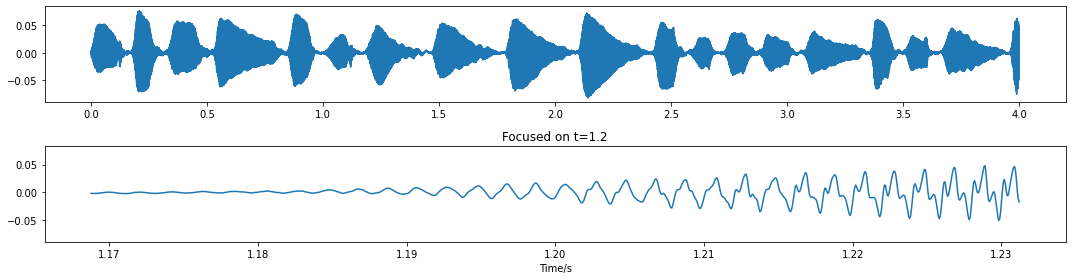

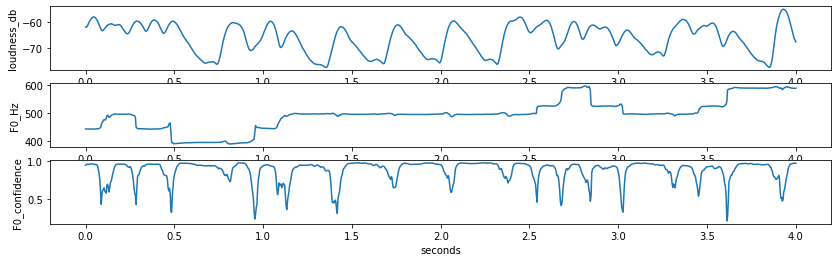

In [33]:
%load_ext autoreload
%autoreload 2

from ddsp.colab import jupyter_utils
import ddsp.training
from matplotlib import pyplot as plt
import numpy as np

TRAIN_TFRECORD_FILEPATTERN = "/Users/p378593/Documents/URMP/mini-urmp-mono/*"
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
print(data_provider is ddsp.training.data.DataProvider)
dataset = data_provider.get_batch(4)

for i in iter(dataset):
    for k, v in i.items():
        print(k, v.shape)
    break

try:
    ex = next(iter(dataset))
except StopIteration:
    raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

ex = next(iter(dataset))
jupyter_utils.show_audio(ex['audio'][0])

f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'][0])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')
ax[1].plot(x, ex['f0_hz'][0])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'][0])

In [29]:
ddsp.training.data.TFRecordProvider.__bases__[0].__bases__[0].get_batch

<function ddsp.training.data.DataProvider.get_batch(self, batch_size, shuffle=True, repeats=-1)>

# Init Model

In [39]:
import warnings
warnings.filterwarnings("ignore")

import time

import ddsp
from ddsp.training import (data, decoders, encoders, models, preprocessing, 
                           train_util, trainers, discriminator)
import gin
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

sample_rate = 16000
n_samples = 4*sample_rate

strategy = train_util.get_strategy()

with strategy.scope():
    TIME_STEPS = 1000

    # Create Neural Networks.
    preprocessor = preprocessing.F0LoudnessPreprocessor(time_steps=TIME_STEPS)

    decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                    rnn_type = 'gru',
                                    ch = 256,
                                    layers_per_stack = 1,
                                    input_keys = ('ld_scaled', 'f0_scaled', 'z'),
                                    output_splits = (('amps', 1),
                                                    ('harmonic_distribution', 45),
                                                    ('noise_magnitudes', 45)))

    # Create Processors.
    harmonic = ddsp.synths.Harmonic(n_samples=n_samples, 
                                    sample_rate=sample_rate,
                                    name='harmonic')

    noise = ddsp.synths.FilteredNoise(window_size=0,
                                    initial_bias=-10.0,
                                    name='noise')
    add = ddsp.processors.Add(name='add')

    # Create ProcessorGroup.
    dag = [(harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
        (noise, ['noise_magnitudes']),
        (add, ['noise/signal', 'harmonic/signal'])]

    processor_group = ddsp.processors.ProcessorGroup(dag=dag,
                                                    name='processor_group')


    # Loss_functions
    spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                            mag_weight=1.0,
                                            logmag_weight=1.0)
    
    encoder = encoders.MfccTimeDistributedRnnEncoder(rnn_channels = 512, rnn_type = 'gru', z_dims = 16, z_time_steps = 125)
    
    critic = discriminator.ParallelWaveGANDiscriminator(input_keys=['discriminator_audio'])
    model = models.Autoencoder(preprocessor=preprocessor,
                                encoder=encoder,
                                decoder=decoder,
                                processor_group=processor_group,
                                discriminator=critic,
                                losses=[spectral_loss])
    trainer = trainers.Trainer(model, strategy, learning_rate=1e-3)
    dataset = trainer.distribute_dataset(dataset)
    trainer.build(next(iter(dataset)))
    dataset_iter = iter(dataset)
    
    for i in range(3000):
        losses = trainer.train_step(dataset_iter)
        res_str = 'step: {}\t'.format(i)
        for k, v in losses.items():
            res_str += '{}: {:.2f}\t'.format(k, v)
        print(res_str)

        if i % 300 == 1:
            print(f"Step {i}")
            trainer.save("gan1")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


RnnFcDecoder:
{'ld_scaled': TensorShape([4, 1000, 256]), 'f0_scaled': TensorShape([4, 1000, 256]), 'z': TensorShape([4, 1000, 256])}
Discriminator input: [TensorShape([4, 64000, 1])]
RnnFcDecoder:
{'ld_scaled': TensorShape([4, 1000, 256]), 'f0_scaled': TensorShape([4, 1000, 256]), 'z': TensorShape([4, 1000, 256])}
Discriminator input: [TensorShape([4, 64000, 1])]
Model: "autoencoder_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
f0_loudness_preprocessor_6 ( multiple                  0         
_________________________________________________________________
mfcc_time_distributed_rnn_en multiple                  843852    
_________________________________________________________________
rnn_fc_decoder_6 (RnnFcDecod multiple                  1081179   
_________________________________________________________________
processor_group (ProcessorGr multiple                  0         
_________________

INFO:tensorflow:Error reported to Coordinator: in user code:

    /Users/p378593/Documents/ddsp/ddsp/training/trainers.py:172 step_fn  *
        d_losses, grads = self.model.discriminator_step_fn(outputs)
    /Users/p378593/Documents/ddsp/ddsp/training/models/autoencoder.py:107 discriminator_step_fn  *
        scores = self.discriminator(batch)['score']
    /Users/p378593/Documents/ddsp/ddsp/training/nn.py:136 __call__  *
        outputs = super().__call__(*inputs, **kwargs)
    /Users/p378593/Documents/ddsp/ddsp/training/discriminator.py:25 call  *
        score  = self.compute_score(*inputs)
    /Users/p378593/Documents/ddsp/ddsp/training/discriminator.py:93 compute_score  *
        x = f(x)
    /Users/p378593/miniconda3/envs/ddsp/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/p378593/miniconda3/envs/ddsp/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:372

ValueError: in user code:

    /Users/p378593/Documents/ddsp/ddsp/training/trainers.py:159 train_step  *
        losses = self.run(self.step_fn, batch)
    /Users/p378593/Documents/ddsp/ddsp/training/trainers.py:139 run  *
        return self.strategy.run(fn, args=args, kwargs=kwargs)
    /Users/p378593/miniconda3/envs/ddsp/lib/python3.8/site-packages/tensorflow/python/distribute/mirrored_run.py:96 call_for_each_replica  *
        return _call_for_each_replica(strategy, fn, args, kwargs)
    /Users/p378593/Documents/ddsp/ddsp/training/trainers.py:172 step_fn  *
        d_losses, grads = self.model.discriminator_step_fn(outputs)
    /Users/p378593/Documents/ddsp/ddsp/training/models/autoencoder.py:107 discriminator_step_fn  *
        scores = self.discriminator(batch)['score']
    /Users/p378593/Documents/ddsp/ddsp/training/nn.py:136 __call__  *
        outputs = super().__call__(*inputs, **kwargs)
    /Users/p378593/Documents/ddsp/ddsp/training/discriminator.py:25 call  *
        score  = self.compute_score(*inputs)
    /Users/p378593/Documents/ddsp/ddsp/training/discriminator.py:93 compute_score  *
        x = f(x)
    /Users/p378593/miniconda3/envs/ddsp/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/p378593/miniconda3/envs/ddsp/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:372 call  **
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /Users/p378593/miniconda3/envs/ddsp/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:385 call
        return self._run_internal_graph(
    /Users/p378593/miniconda3/envs/ddsp/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/p378593/miniconda3/envs/ddsp/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /Users/p378593/miniconda3/envs/ddsp/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:224 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer weight_normalization_54: expected shape=(None, 64002, 1), found shape=[4, 6, 64000]


In [36]:
outputs = model(ex)
outputs.keys()

RnnFcDecoder:
{'ld_scaled': TensorShape([4, 1000, 256]), 'f0_scaled': TensorShape([4, 1000, 256]), 'z': TensorShape([4, 1000, 256])}


dict_keys(['inputs', 'audio', 'f0_confidence', 'f0_hz', 'loudness_db', 'f0_scaled', 'ld_scaled', 'z', 'amps', 'harmonic_distribution', 'noise_magnitudes', 'harmonic', 'noise', 'add', 'out', 'audio_synth'])

In [37]:
ex['discriminator_audio'] = ex['audio']
critic(ex)

{'score': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.07081453, 0.05903753, 0.47411618, 0.73114365], dtype=float32)>}

In [20]:
outputs['discriminator_audio'].shape

TensorShape([1, 64000])

AttributeError: 'DistributedDataset' object has no attribute 'get_batch'

In [23]:
type(dataset)

tensorflow.python.distribute.input_lib.DistributedDataset